# ECG Challenge

[GitHub link](https://github.com/idoven/Idoven-Data-Scientist)

-----------
Aurora Cobo Aguilera

a.cobo.aguilera@gmail.com

8th May 2023

------------

In the following notebook, I present a solution to process the database provided about ECG signals and their diagnostics. This is a basic program and I did my best taking into consideration that I am not medician and this is my first time working with ECG signals. If I were in the team, my firt step would be talking to a doctor to understand better the data and discover the most valuable variables in the database.

Saying all of this, I hope you enjoy the notebook and I apologize for the mistakes I may have done regarding the interpretation.

## 1. Loading and discovering the data

In every ML problem I have, my first step is traying to become an expert about the data. The more I know about it, the best models I can fit to it. Biases, errors, missing data, imbalanced data.... all these concepts are super important before modeling the data.

The first part of the code is the installation of libraries and importing them.

In [1]:
!pip install wfdb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.9/159.9 kB 6.3 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import wfdb
import ast
from scipy.signal import find_peaks

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, multilabel_confusion_matrix, classification_report
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns



In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 1.1 Loading all the data and extracting general information about it

In [4]:
def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

You may change the following path to obtain the data regarding your directory in drive where you have saved it.

In [5]:
path = '/content/drive/MyDrive/Colab Notebooks/Idoven interview/data/'

# load and convert annotation data
Y = pd.read_csv(path + 'ptbxl_database.csv', index_col='ecg_id')


In [6]:
Y.head()

,patient_id,age,sex,height,weight,nurse,site,device,recording_date,report,...,SLI-LVH,QRS-CLBB,ST-ELEV-MI,ST-DEPR-MI,Q-ISC,Q-ISC-QPeak,Q-ISC-V2V3,Q-ISC-RPeak,STRAIN,MI-ALL
ecg_id,,,,,,,,,,,,,,,,,,,,,
1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,sinusrhythmus periphere niederspannung,...,False,False,False,False,False,False,False,False,False,False
2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,sinusbradykardie sonst normales ekg,...,True,False,False,False,False,False,False,False,False,False
3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,sinusrhythmus normales ekg,...,False,False,False,False,False,False,False,False,False,False
4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,sinusrhythmus normales ekg,...,False,False,False,False,False,False,False,False,False,False
5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,sinusrhythmus normales ekg,...,False,False,False,False,False,False,False,False,False,False


In [7]:
Y.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21801 entries, 1 to 21837
Data columns (total 43 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   patient_id                    21801 non-null  float64
 1   age                           21801 non-null  float64
 2   sex                           21801 non-null  int64  
 3   height                        6975 non-null   float64
 4   weight                        9422 non-null   float64
 5   nurse                         20326 non-null  float64
 6   site                          21783 non-null  float64
 7   device                        21801 non-null  object 
 8   recording_date                21801 non-null  object 
 9   report                        21801 non-null  object 
 10  scp_codes                     21801 non-null  object 
 11  heart_axis                    13331 non-null  object 
 12  infarction_stadium1           5613 non-null   object 
 13  i

In [8]:
pd.isna(Y).sum()

patient_id                          0
age                                 0
sex                                 0
height                          14826
weight                          12379
nurse                            1475
site                               18
device                              0
recording_date                      0
report                              0
scp_codes                           0
heart_axis                       8470
infarction_stadium1             16188
infarction_stadium2             21698
validated_by                     9380
second_opinion                      0
initial_autogenerated_report        0
validated_by_human                  0
baseline_drift                  20202
static_noise                    18541
burst_noise                     21188
electrodes_problems             21771
extra_beats                     19852
pacemaker                       21510
strat_fold                          0
filename_lr                         0
filename_hr 

Variables with many missing data are not suitable for training a traditional ML model. For them ,you need more time to preprocess and impute their values. Since tihs is a fasta challenge, I will omit this step, but in real world problems, with more time, I would try not to waste this information.

With this reflection, I will focus in, for example, last variables, from RS-LVH to MI-ALL, of boolean type and no missing values among them. I might try to add age and sex to this variables, since it may incorporate key information to the diagnosis. In my experience with models applied to patients data, doctor told me to inlcude that information too.

I guess that these last variables are heart conditions directly related to heart diseases, so they are a main source of information for our models.

In [9]:
Y['filename_hr']

ecg_id
1        records500/00000/00001_hr
2        records500/00000/00002_hr
3        records500/00000/00003_hr
4        records500/00000/00004_hr
5        records500/00000/00005_hr
                   ...            
21833    records500/21000/21833_hr
21834    records500/21000/21834_hr
21835    records500/21000/21835_hr
21836    records500/21000/21836_hr
21837    records500/21000/21837_hr
Name: filename_hr, Length: 21801, dtype: object

In [10]:
Y['filename_lr']

ecg_id
1        records100/00000/00001_lr
2        records100/00000/00002_lr
3        records100/00000/00003_lr
4        records100/00000/00004_lr
5        records100/00000/00005_lr
                   ...            
21833    records100/21000/21833_lr
21834    records100/21000/21834_lr
21835    records100/21000/21835_lr
21836    records100/21000/21836_lr
21837    records100/21000/21837_lr
Name: filename_lr, Length: 21801, dtype: object

In addtition to this metadata and annotation, we are provided the ECG original signals, so they can also be used as the main data to train a classification model, for example. They are stored in 2 different frequencies in the files defined in the previous columns.

In [11]:
Y.scp_codes[1]

"{'NORM': 100.0, 'LVOLT': 0.0, 'SR': 0.0}"

The classification model mentioned before could be use to predict the diagnosis of the patient given the ECG signal or the annotations on it. I will try to develop both cases in the following sections of the notebook. But first, we need to know what we have to classify. Look at the previous code cell output. *scp_codes* seems to have diagnosis information!

In [12]:
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))


We change the format from text to python dictionary so we can acces to it.

In [13]:
Y.scp_codes[1]

{'NORM': 100.0, 'LVOLT': 0.0, 'SR': 0.0}

et voilà!

In [14]:
# Load scp_statements.csv for diagnostic aggregation
agg_df = pd.read_csv(path + 'scp_statements.csv', index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]

We are also provided a dictionary to sort the heart abnormalities in categories. This is the look of it:

In [15]:
agg_df.head()

,description,diagnostic,form,rhythm,diagnostic_class,diagnostic_subclass,Statement Category,SCP-ECG Statement Description,AHA code,aECG REFID,CDISC Code,DICOM Code
NDT,non-diagnostic T abnormalities,1.0,1.0,NaN,STTC,STTC,other ST-T descriptive statements,non-diagnostic T abnormalities,NaN,NaN,NaN,NaN
NST_,non-specific ST changes,1.0,1.0,NaN,STTC,NST_,Basic roots for coding ST-T changes and abnorm...,non-specific ST changes,145.0,MDC_ECG_RHY_STHILOST,NaN,NaN
DIG,digitalis-effect,1.0,1.0,NaN,STTC,STTC,other ST-T descriptive statements,suggests digitalis-effect,205.0,NaN,NaN,NaN
LNGQT,long QT-interval,1.0,1.0,NaN,STTC,STTC,other ST-T descriptive statements,long QT-interval,148.0,NaN,NaN,NaN
NORM,normal ECG,1.0,NaN,NaN,NORM,NORM,Normal/abnormal,normal ECG,1.0,NaN,NaN,F-000B7


The following code uses the previous dictionary to encode the diagnosis in the database loaded first. Next, we create a new column with this information.

In [16]:
# Apply diagnostic superclass
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)

In [17]:
Y.head()

,patient_id,age,sex,height,weight,nurse,site,device,recording_date,report,...,QRS-CLBB,ST-ELEV-MI,ST-DEPR-MI,Q-ISC,Q-ISC-QPeak,Q-ISC-V2V3,Q-ISC-RPeak,STRAIN,MI-ALL,diagnostic_superclass
ecg_id,,,,,,,,,,,,,,,,,,,,,
1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,sinusrhythmus periphere niederspannung,...,False,False,False,False,False,False,False,False,False,[NORM]
2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,sinusbradykardie sonst normales ekg,...,False,False,False,False,False,False,False,False,False,[NORM]
3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,sinusrhythmus normales ekg,...,False,False,False,False,False,False,False,False,False,[NORM]
4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,sinusrhythmus normales ekg,...,False,False,False,False,False,False,False,False,False,[NORM]
5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,sinusrhythmus normales ekg,...,False,False,False,False,False,False,False,False,False,[NORM]


This is the label to predict in our classification problem!: 'diagnostic_superclass'. However, I underline that this is a simplified version cause we have joined pathologies in general categories, but we could have separated them in the subclasses to solved a little bit more complex problem with more classes.

These are the possible 5 classes in our scenario:


In [18]:
agg_df.diagnostic_class.value_counts()

MI      14
STTC    13
CD      11
HYP      5
NORM     1
Name: diagnostic_class, dtype: int64

Each signal may have zero, one or more abnormalities. Therefore, we have a multilabel classification problem.

In [19]:
Y.diagnostic_superclass.apply(len).value_counts()

1    16248
2     4072
3      919
0      405
4      157
Name: diagnostic_superclass, dtype: int64

But the majority of the samples,

In [20]:
print('{} ({}%)'.format(Y.diagnostic_superclass.apply(len).value_counts()[1], Y.diagnostic_superclass.apply(len).value_counts()[1]/len(Y)*100))

16248 (74.52869134443374%)


have a single class.

Let's look at the classes appareance:

In [21]:
Y.diagnostic_superclass

ecg_id
1        [NORM]
2        [NORM]
3        [NORM]
4        [NORM]
5        [NORM]
          ...  
21833    [STTC]
21834    [NORM]
21835    [STTC]
21836    [NORM]
21837    [NORM]
Name: diagnostic_superclass, Length: 21801, dtype: object

We have to code them! My ML model does not understand letters but numbers!

In [22]:
# Perform one-hot encoding
mlb = MultiLabelBinarizer()
y_encoded = mlb.fit_transform(Y.diagnostic_superclass)

*y_encoded* do have the codification of the classes.

And these are the different classes we have:

In [23]:
print(mlb.classes_)

['CD' 'HYP' 'MI' 'NORM' 'STTC']


In [24]:
y_encoded.shape

(21801, 5)

Here it is shown some examples of multiclass labels:

In [25]:
Y.diagnostic_superclass[np.sum(y_encoded, axis=1)==2]

ecg_id
39       [MI, STTC]
45        [HYP, CD]
50         [MI, CD]
77         [MI, CD]
87       [STTC, CD]
            ...    
21815      [MI, CD]
21821    [NORM, CD]
21827    [MI, STTC]
21828    [MI, STTC]
21829    [NORM, CD]
Name: diagnostic_superclass, Length: 4072, dtype: object

### 1.2 Loading the boolean data

Among all data, let's save the one that can be more valuable a priori.

In [26]:
Y[Y.columns[28:-1]]

,RS-LVH,S12-LVH,R56-LVH,QRS-LVH,LI-LVH,SLI-LVH,QRS-CLBB,ST-ELEV-MI,ST-DEPR-MI,Q-ISC,Q-ISC-QPeak,Q-ISC-V2V3,Q-ISC-RPeak,STRAIN,MI-ALL
ecg_id,,,,,,,,,,,,,,,
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
5,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21833,False,False,False,True,True,False,False,False,True,False,False,False,False,False,True
21834,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
21835,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False


In [27]:
X_kpi = Y[Y.columns[28:-1]]

We convert to integer all variables.

In [28]:
X_kpi = X_kpi.applymap(int)
X_kpi.head()

,RS-LVH,S12-LVH,R56-LVH,QRS-LVH,LI-LVH,SLI-LVH,QRS-CLBB,ST-ELEV-MI,ST-DEPR-MI,Q-ISC,Q-ISC-QPeak,Q-ISC-V2V3,Q-ISC-RPeak,STRAIN,MI-ALL
ecg_id,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


### 1.2 Loading extra data

We may want to extract age and sex from patients too.

In [29]:
X_extra = Y[['age', 'sex']]
X_extra.head()

,age,sex
ecg_id,,
1,56.0,1
2,19.0,0
3,37.0,1
4,24.0,0
5,19.0,1


### 1.3 Loading the signal data

In [ ]:
sampling_rate = 100

# Load raw signal data
X_signal = load_raw_data(Y, sampling_rate, path)

We can print an example of the ECG signals from a record defined by ecg_id.

In [ ]:
# Set the time axis based on the sampling rate and number of samples
sampling_rate = 100  # Hz
num_samples = 1000
time = pd.timedelta_range(start=0, periods=num_samples, freq=f"{1000/sampling_rate}ms")

# Create a figure and subplots for each ECG lead
fig, axs = plt.subplots(12, 1, figsize=(10, 20), sharex=True)

ecg_id = 0
# Iterate over each ECG lead column
for i, column in enumerate(range(X_signal.shape[2])):
    # Get the ECG signal from the column
    signal = X_signal[ecg_id, :, column]

    # Plot the ECG signal
    axs[i].plot(time, signal)
    axs[i].set_ylabel(f"Lead {i + 1}")

# Set the x-axis label and title
axs[-1].set_xlabel("Time (ns)")
fig.suptitle("ECG Signals")

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

Executing it in my computer........ this is the result

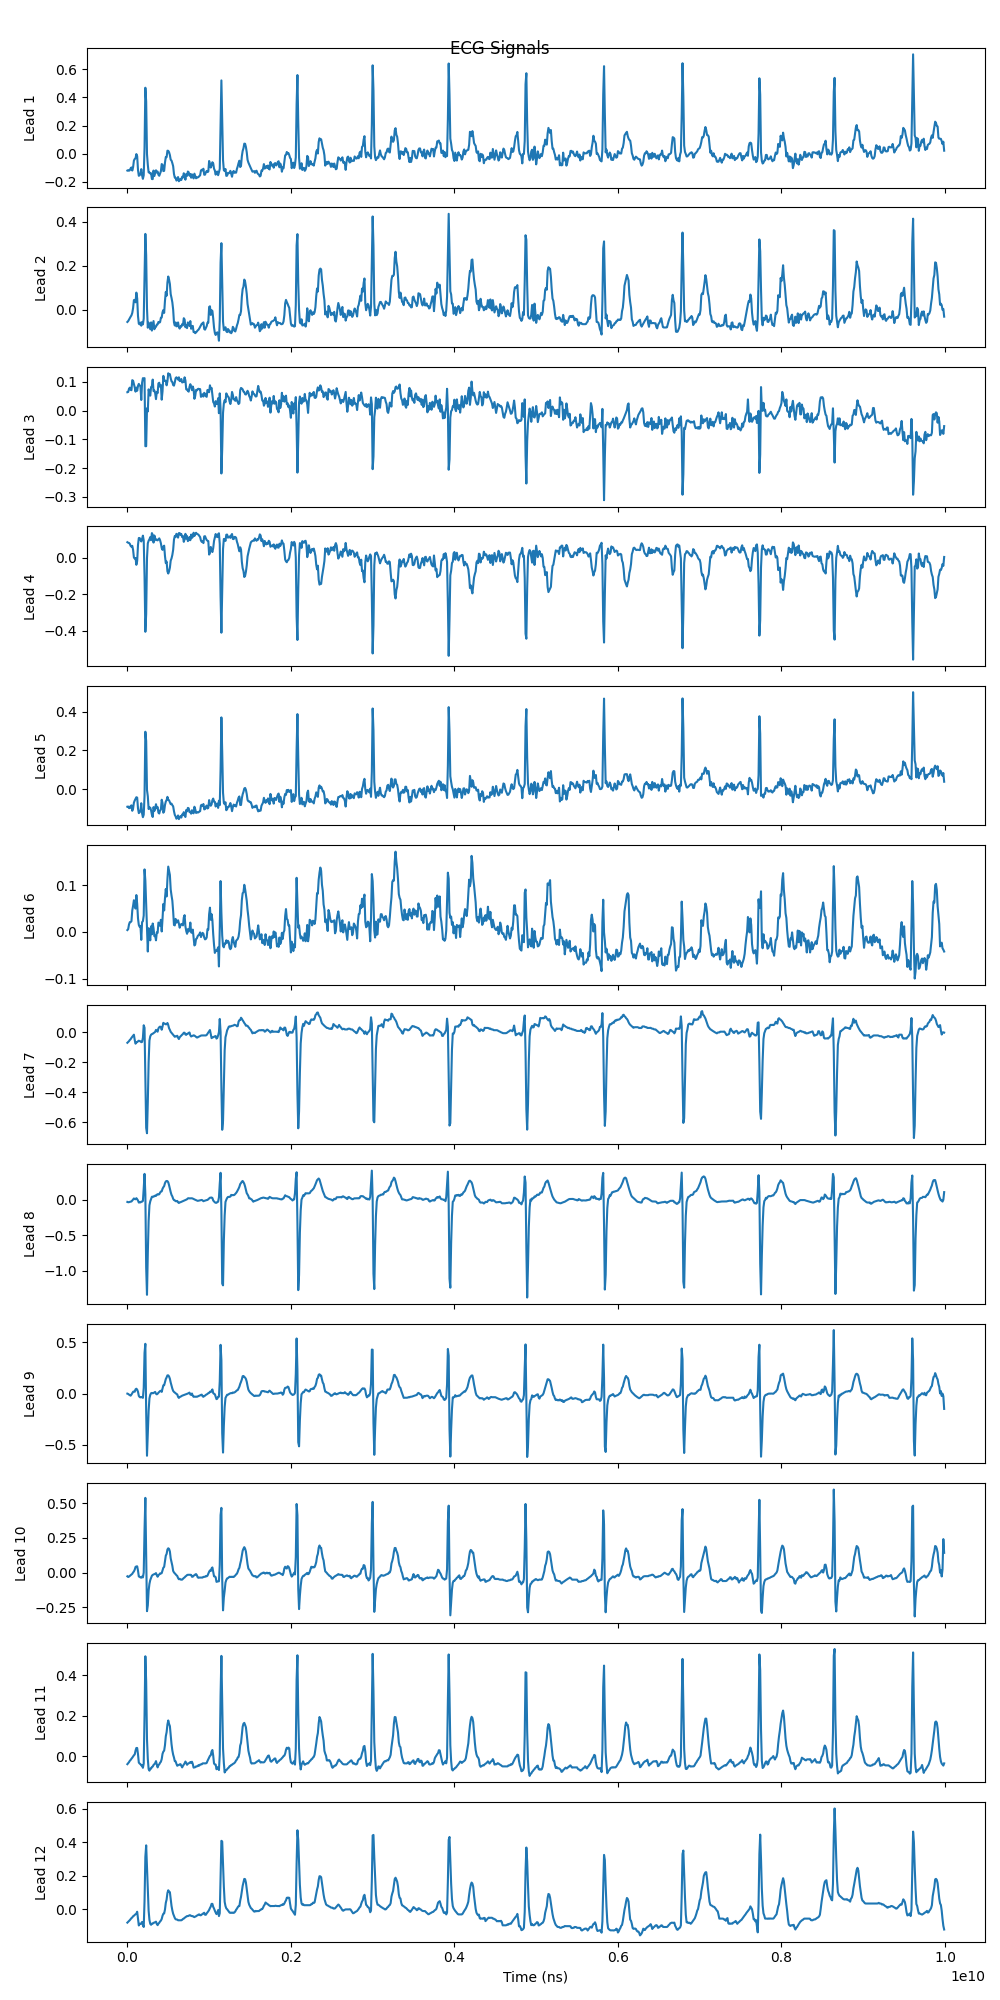

### 1.4 Split data in train and test 

In [30]:
# Split data into train and test
test_fold = 10
# Train
X_kpi_train = X_kpi[(Y.strat_fold != test_fold)]
#y_train = Y[(Y.strat_fold != test_fold)].diagnostic_superclass
y_encoded_train = y_encoded[(Y.strat_fold != test_fold)]

# Test
X_kpi_test = X_kpi[(Y.strat_fold == test_fold)]
#y_test = Y[Y.strat_fold == test_fold].diagnostic_superclass
y_encoded_test = y_encoded[(Y.strat_fold == test_fold)]


In [31]:
print(X_kpi_train.shape)
print(y_encoded_train.shape)
print(X_kpi_test.shape)
print(y_encoded_test.shape)

(19603, 15)
(19603, 5)
(2198, 15)
(2198, 5)


In [ ]:
# Train
X_signal_train = X_signal[np.where(Y.strat_fold != test_fold)]

# Test
X_signal_test = X_signal[np.where(Y.strat_fold == test_fold)]

### 1.5 Data Normalization

In [32]:
# Feature Scaling
scaler = StandardScaler()
X_kpi_train_scaled = scaler.fit_transform(X_kpi_train)
X_kpi_test_scaled = scaler.transform(X_kpi_test)

## 2. Model 1: Classifier with the markers

First, we are going to try traditional ML to solve the classification problem, since it is the easier scenario. We have to check if simpler solutions are enough.


### 2.1 SVC Multilabel classifier

In [ ]:
# Initialize the base estimator
base_estimator = SVC(kernel='rbf')

# Initialize the MultiOutputClassifier with the base estimator
multi_output_classifier = MultiOutputClassifier(base_estimator)

# Define the parameter grid for grid search
param_grid = {
    'estimator__C': [0.1, 1.0, 10.0],
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(multi_output_classifier, param_grid, cv=5)
grid_search.fit(X_kpi_train_scaled, y_encoded_train)

# Get the best trained model
best_model = grid_search.best_estimator_

# Predict the labels for the testing data
y_pred = best_model.predict(X_kpi_test_scaled)

# Evaluate the model
accuracy = best_model.score(X_kpi_test_scaled, y_encoded_test)

# Print the best parameters and accuracy
print("Best Parameters:", grid_search.best_params_)
print("Accuracy:", accuracy)

### 2.3 Random Forest Multilabel classifier

In [ ]:
# Initialize the base estimator
base_estimator = RandomForestClassifier()

# Initialize the MultiOutputClassifier with the base estimator
multi_output_classifier = MultiOutputClassifier(base_estimator)

# Define the parameter grid for grid search
param_grid = {
    'estimator__n_estimators': [50, 100, 200]
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(multi_output_classifier, param_grid, cv=5)
grid_search.fit(X_kpi_train_scaled, y_encoded_train)

# Get the best trained model
best_model = grid_search.best_estimator_

# Predict the labels for the testing data
y_pred = best_model.predict(X_kpi_test_scaled)

# Evaluate the model
accuracy = best_model.score(X_kpi_test_scaled, y_encoded_test)

# Print the best parameters and accuracy
print("Best Parameters:", grid_search.best_params_)
print("Accuracy:", accuracy)

Best Parameters: {'estimator__n_estimators': 200}
Accuracy: 0.4822565969062784


### 2.2 KNN Multilabel Classifier

In [ ]:
# Initialize the base estimator
base_estimator = KNeighborsClassifier()

# Initialize the MultiOutputClassifier with the base estimator
multi_output_classifier = MultiOutputClassifier(base_estimator)

# Define the parameter grid for grid search
param_grid = {
    'estimator__n_neighbors': [1, 3, 5, 7, 10, 15, 20]
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(multi_output_classifier, param_grid, cv=5)
grid_search.fit(X_kpi_train_scaled, y_encoded_train)

# Get the best trained model
best_model = grid_search.best_estimator_

# Predict the labels for the testing data
y_pred = best_model.predict(X_kpi_test_scaled)

# Evaluate the model
accuracy = best_model.score(X_kpi_test_scaled, y_encoded_test)

# Print the best parameters and accuracy
print("Best Parameters:", grid_search.best_params_)
print("Accuracy:", accuracy)

Best Parameters: {'estimator__n_neighbors': 20}
Accuracy: 0.49909008189262966


We can confirm that none of the previous models have a decent accuracy so this is not the best way to deal this problem.

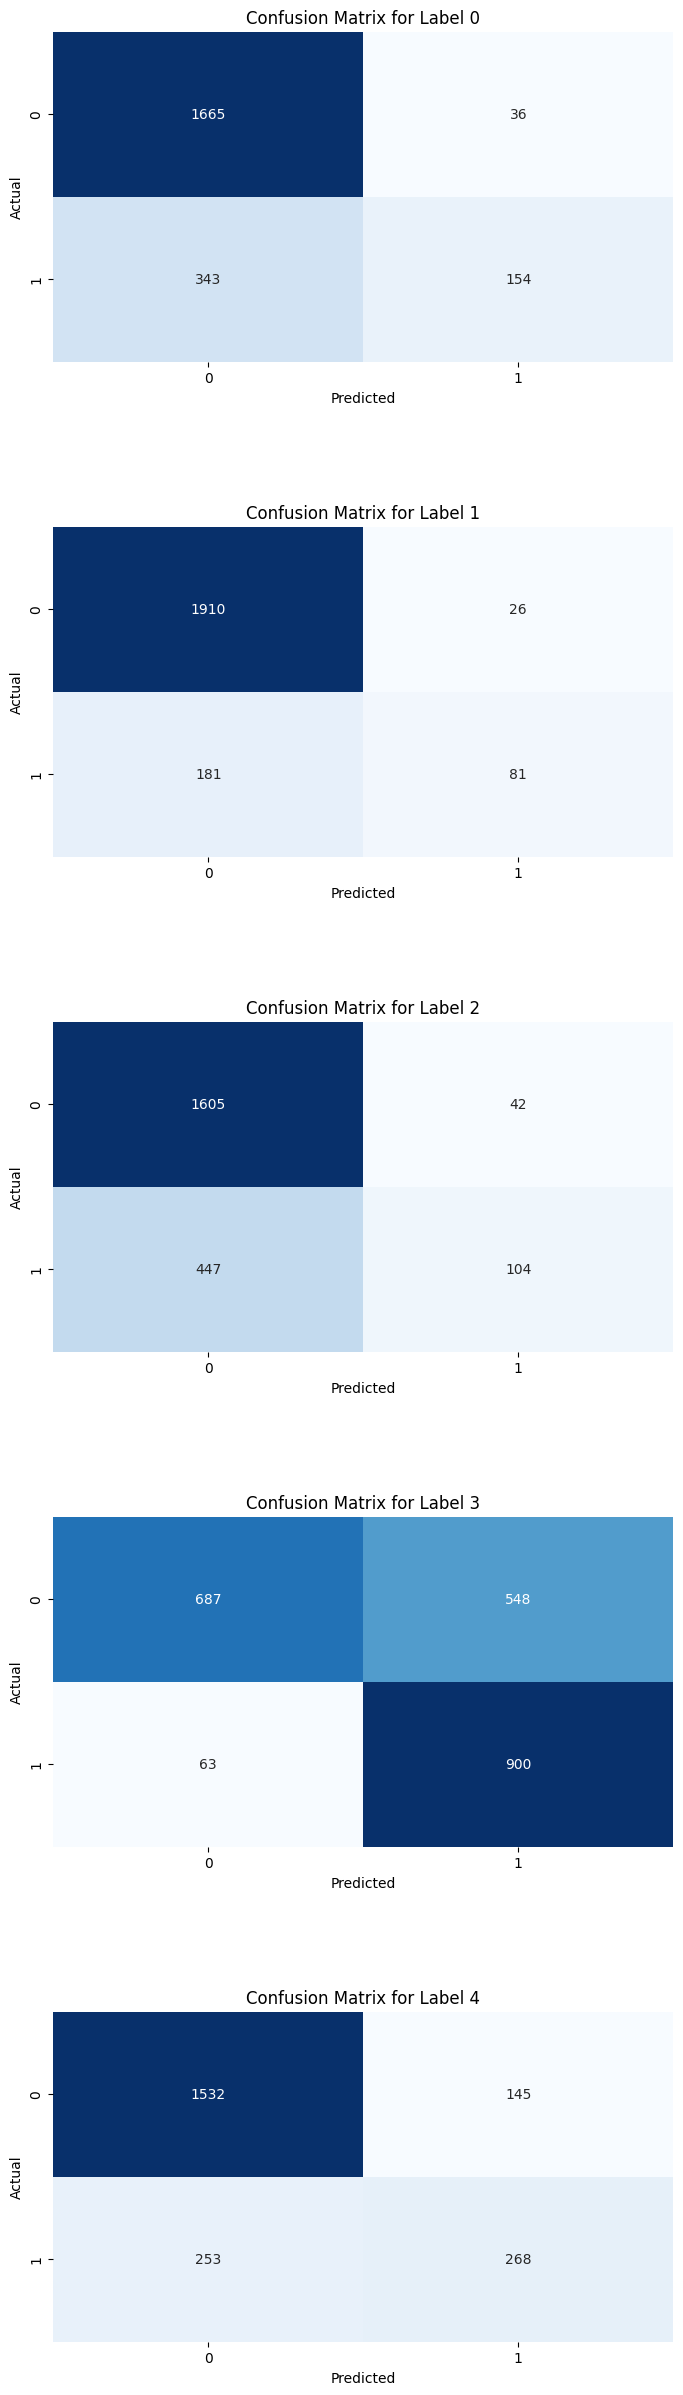

In [ ]:
# Compute the confusion matrix
confusion_matrix = multilabel_confusion_matrix(y_encoded_test, y_pred)

# Plot the confusion matrix
fig, axs = plt.subplots(nrows=len(confusion_matrix), figsize=(8, 6*len(confusion_matrix)))
plt.subplots_adjust(hspace=0.5)

for i, cm in enumerate(confusion_matrix):
    label_name = f"Label {i}"
    ax = axs[i]
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)
    ax.set_title(f"Confusion Matrix for {label_name}")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

plt.show()

And the class *NORM* is the one with more errors.

## 3. Identify important params in the ECG signals

In [ ]:
# Select a specific lead for analysis (e.g., Lead I)
lead_index = 0
ecg_lead = X_signal_train[0, :, lead_index]
fs = 100

# Preprocess the ECG signal if needed (e.g., filtering, noise removal, baseline correction)

# Perform R-peak detection
r_peaks, _ = find_peaks(ecg_lead, distance=100)

# Calculate heartbeat intervals
heartbeats_intervals = np.diff(r_peaks) / fs  # Convert to time intervals

# Calculate average heartbeat interval
average_interval = np.mean(heartbeats_intervals)

# Calculate total number of heartbeats
total_heartbeats = len(r_peaks)

# Print the results
print("Average Heartbeat Interval: {:.2f} seconds".format(average_interval))
print("Total Number of Heartbeats: {}".format(total_heartbeats))

Results:

Average Heartbeat Interval: 1.56 seconds

Total Number of Heartbeats: 7

## 4. Model 2: Classifier with the signals

In this section we are trying to train a classifier to predict between the 5 diagnostics- For that, we are using the signal information. This is a complicated information to use cause the dimensions are too high: 1000 samples and 12 lead per case are 12000 features, not suitable for training traditional ML models. 

In this notebook I only show traditional ML, cause I did not have the time and resources avaible in the moment to explore mode complex model as Transformers. That would be my exploration area in a real situation.

### Choice 1

First, we are trying to use a library to extract some features from our signals. After that, we apply a Random Forest classifier. We did not use any technique to improve generalization because of the execution time. But the minimum step we must include is cross validation. We include data normalization before the model training.

In [ ]:
# Define the wavelet function and decomposition level
wavelet = 'db4'
level = 5

# Initialize an empty list to store the extracted features
features = []

# Extract wavelet coefficients for each ECG record
for ecg_record in X_signal_train:
    record_features = []
    for lead in ecg_record:
        coeffs = pywt.wavedec(lead, wavelet, level=level)
        for coeff in coeffs:
            record_features.extend(coeff)
    features.append(record_features)

# Convert the features list to a NumPy array
train_features = np.array(features)


# Initialize an empty list to store the extracted features
features = []

# Extract wavelet coefficients for each ECG record
for ecg_record in X_signal_test:
    record_features = []
    for lead in ecg_record:
        coeffs = pywt.wavedec(lead, wavelet, level=level)
        for coeff in coeffs:
            record_features.extend(coeff)
    features.append(record_features)

# Convert the features list to a NumPy array
test_features = np.array(features)


# Standardize the data
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
test_features_scaled = scaler.transform(test_features)


# Create and train the classifier
classifier = RandomForestClassifier()
classifier.fit(train_features_scaled, y_encoded_train)

# Predict the labels for the test set
y_pred = classifier.predict(test_features_scaled)


# Calculate accuracy and generate classification report
accuracy = accuracy_score(y_encoded_test, y_pred)
report = classification_report(y_encoded_test, y_pred)

# Print the results
print('Accuracy:', accuracy)
print('Classification Report:')
print(report)

The following results were obtained in my laptop cause notebook execution were too slow.

Accuracy: 0.2829845313921747

Classification Report:

              precision    recall  f1-score   support
           0       0.93      0.05      0.10       497
           1       0.00      0.00      0.00       262
           2       0.73      0.05      0.09       551
           3       0.78      0.62      0.69       963
           4       0.73      0.02      0.04       521
   micro avg       0.78      0.24      0.36      2794

   macro avg       0.63      0.15      0.19      2794
   
weighted avg       0.72      0.24      0.28      2794

 samples avg       0.30      0.28      0.29      2794

They are not good enough

### Choice 2


In [ ]:

# Flatten the ECG data
X_signal_train_flattened = X_signal_train.reshape(X_signal_train.shape[0], -1)
X_signal_test_flattened = X_signal_test.reshape(X_signal_test.shape[0], -1)

# Standardize the flattened data
scaler = StandardScaler()
X_signal_train_flattened_scaled = scaler.fit_transform(X_signal_train_flattened)
X_signal_test_flattened_scaled = scaler.transform(X_signal_test_flattened)


# Define the number of components to keep
n_components = 50  # Adjust the number of components as needed

# Create a PCA object
pca = PCA(n_components=n_components)

# Apply PCA to the flattened data
X_train_PCA = pca.fit_transform(X_signal_train_flattened_scaled)
X_test_PCA = pca.transform(X_signal_test_flattened_scaled)


# Define the parameter grid for GridSearchCV
param_grid = {'n_neighbors': [3, 5, 7, 10, 20, 30, 50]}  # Adjust the values of n_neighbors as needed

# Create the KNN classifier
knn = KNeighborsClassifier()

# Create the GridSearchCV object
grid_search = GridSearchCV(knn, param_grid, cv=5)  # Adjust the number of cross-validation folds (cv) as needed

# Perform grid search
grid_search.fit(X_train_PCA, y_encoded_train)


# Predict the labels for the test set
y_pred = classifier.predict(X_test_PCA)

# Calculate accuracy and generate classification report
accuracy = accuracy_score(y_encoded_test, y_pred)
report = classification_report(y_encoded_test, y_pred)

# Print the results
print('Accuracy:', accuracy)
print('Classification Report:')
print(report)

Accuracy: 0.2556869881710646

Classification Report:

              precision    recall  f1-score   support
           0       0.77      0.07      0.13       497
           1       0.00      0.00      0.00       262
           2       0.33      0.00      0.01       551
           3       0.60      0.57      0.58       963
           4       0.00      0.00      0.00       521

   micro avg       0.60      0.21      0.31      2794

   macro avg       0.34      0.13      0.14      2794

weighted avg       0.41      0.21      0.23      2794

 samples avg       0.27      0.25      0.26      2794

None of the previous strategies seems to work very good for these signals. I would use a Transformer were I can use the time information and treat data as sequencies. That, or any recurrent NN would be better that traditional ML.

However, due to the time and resources, I can only express new idea to treat the data but not implement them.

Another option would be simplify the classes to 2, healthy and not healthy heart, or complicate it more to all the subclasses described in the annotation file.

I hope you enjoy my fast work about the data, any doubt you can contact me! :)